### Audio Event Classifier with Deep Learning

Build a CNN sound classifier using melspectograms from ESC-50 data. Refer to *save_melspectorgrams.ipynb* for feature extraction.

In [2]:
%matplotlib inline
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.applications.vgg16 import preprocess_input
from keras.utils import multi_gpu_model
import numpy as np
import json
import pickle

# Set parameter values

In [3]:
batch_size = 16    #intially it was 400
epochs = 15        # intial epochs were 200

# dimensions of our images.
img_width, img_height = 224, 224

input_tensor = Input(shape=(224,224,3))

nb_training_samples = 256    # this was 1600
nb_validation_samples = 64   # this was 400   # Set parameter values

# Configure training and validation data generators

Provide paths to training and testing set directores

In [4]:
# training generator configuration
training_data_dir = '/home/amnayak/Downloads/ESC-50-master/melspectrograms/training'   #please change the path 

training_datagen = image.ImageDataGenerator(
    rescale=1./255)

training_generator = training_datagen.flow_from_directory(
    training_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

# validation generator configuration
validation_data_dir ='/home/amnayak/Downloads/ESC-50-master/melspectrograms/testing/'   #please change the path 

validation_datagen = image.ImageDataGenerator(
    rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size)

Found 256 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# Load base model

In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')
base_model.summary()


Model loaded.
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 12

# Build top model

In [6]:
base_model.output_shape[1:]

(7, 7, 512)

In [7]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))
top_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________


# Combine base model with top model

In [8]:
# top_model.load_weights('bootlneck_fc_model.h5')
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Configure model training

In [9]:
num_layers_to_freeze = 15

In [10]:
from keras import metrics, optimizers

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

for layer in model.layers[:num_layers_to_freeze]:
    layer.trainable = False

# use nesterov accelrated gradient descent ??
# optimizer=optimizers.SGD(lr=1e-4, momentum=0.9, decay=1e-6, nesterov=True)
'''model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_5_accuracy])'''

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False,), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy', top_5_accuracy])


# parallel_model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
#                       loss='categorical_crossentropy', 
#                       metrics=['accuracy', top_5_accuracy])

# serialize model to JSON
model_json = model.to_json()
model_filename = "vgg16_model_{}_frozen_layers.json".format(num_layers_to_freeze)
with open(model_filename, "w") as json_file:
    json_file.write(model_json)

# Fine-tune the model

In [11]:
from keras.callbacks import ModelCheckpoint, TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/layers_frozen_{}".format(num_layers_to_freeze))

# checkpoint
filepath="esc50_vgg16_stft_weights_train_last_2_base_layers.best.hdf5"
best_model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [best_model_checkpoint, tensorboard]

# parallel_model.fit_generator(
#     training_generator,
#     steps_per_epoch=nb_training_samples/batch_size,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,
#     callbacks=callbacks_list)

model.fit_generator(
    training_generator,
    steps_per_epoch=nb_training_samples/batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples/batch_size,
    callbacks=callbacks_list)
# parallel_model.fit_generator(
#     training_generator,
#     samples_per_epoch=nb_training_samples,
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=nb_validation_samples/batch_size,)
#     nb_val_samples=nb_validation_samples)




Epoch 1/15
16/16 [==============================] - 142s 9s/step - loss: 1.2051 - accuracy: 0.5938 - top_5_accuracy: 1.0000 - val_loss: 0.4322 - val_accuracy: 0.9062 - val_top_5_accuracy: 1.0000

Epoch 2/15


/home/amnayak/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


16/16 [==============================] - 139s 9s/step - loss: 0.4577 - accuracy: 0.7930 - top_5_accuracy: 1.0000 - val_loss: 0.2076 - val_accuracy: 0.8906 - val_top_5_accuracy: 1.0000
Epoch 3/15
16/16 [==============================] - 149s 9s/step - loss: 0.3455 - accuracy: 0.8516 - top_5_accuracy: 1.0000 - val_loss: 1.1242 - val_accuracy: 0.5312 - val_top_5_accuracy: 1.0000
Epoch 4/15
16/16 [==============================] - 164s 10s/step - loss: 0.2254 - accuracy: 0.8945 - top_5_accuracy: 1.0000 - val_loss: 0.3106 - val_accuracy: 0.8750 - val_top_5_accuracy: 1.0000
Epoch 5/15
16/16 [==============================] - 148s 9s/step - loss: 0.1924 - accuracy: 0.9258 - top_5_accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 0.9375 - val_top_5_accuracy: 1.0000
Epoch 6/15
16/16 [==============================] - 151s 9s/step - loss: 0.1730 - accuracy: 0.9375 - top_5_accuracy: 1.0000 - val_loss: 0.1858 - val_accuracy: 0.9062 - val_top_5_accuracy: 1.0000
Epoch 7/15
16/16 [=================

# Get top k predictions for selected test files

In [12]:
nb_validation_samples/batch_size

4.0

In [13]:
training_generator.image_shape

(224, 224, 3)

In [14]:
def get_top_k_predictions(preds, label_map, k=5, print_flag=False):
    sorted_array = np.argsort(preds)[::-1]
    top_k = sorted_array[:k]
    label_map_flip = dict((v,k) for k,v in label_map.items())
    
    y_pred = []
    for label_index in top_k:
        if print_flag:
            print ("{} ({})".format(label_map_flip[label_index], preds[label_index]))
        y_pred.append(label_map_flip[label_index])
        
    return y_pred

In [17]:
label_map

{'cough': 0, 'no_cough': 1}

In [16]:
label_map = (training_generator.class_indices)
 
json1 = json.dumps(label_map)
f = open("cough_label_map.json","w")
f.write(json1)
f.close()

img_path = '/home/amnayak/Downloads/ESC-50-master/melspectrograms/testing/cough/2-108017-A-24.png'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)* 1./255

preds = model.predict(x)[0]
print(model.predict(x)[0])
print(get_top_k_predictions(preds, label_map, k=3))


[0.94185257 0.0581474 ]
['cough', 'no_cough']


# Calculate and plot confusion matrix

In [18]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

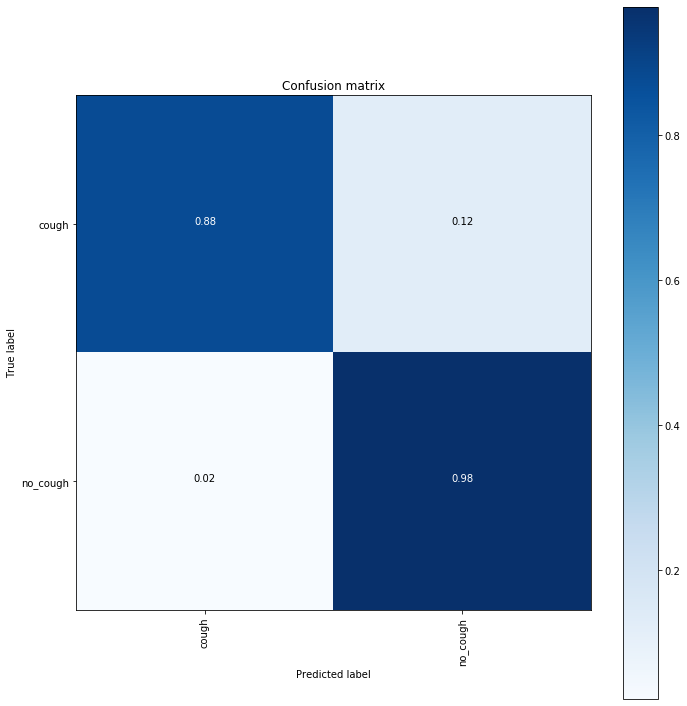

In [19]:
import os
from sklearn.metrics import confusion_matrix

testing_dir = '/home/amnayak/Downloads/ESC-50-master/melspectrograms/testing/'

y_true = []
y_pred = []
xyz=0
for label in label_map.keys():
    file_list = os.listdir(testing_dir + label)
    for file_name in file_list:
        img_path = testing_dir + label + '/' + file_name
        print(xyz,' images predicted...')
        xyz+=1
        img = image.load_img(img_path, target_size=(224, 224))
        
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)* 1./255
        
        preds = model.predict(x)[0]
        
        y_true.append(label)
        y_pred.append(get_top_k_predictions(preds, label_map, k=1)[0])
        
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, sorted(label_map.keys()), normalize=True)

In [30]:
with open('noobs_model.pkl','wb') as file:
    pickle.dump(model,file)